In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [3]:
offense['Year'] += 1
defense['Year'] += 1

In [4]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [5]:
# split out the X and y from combined
X = combined[combined.columns[:-8]].copy()
y = combined[combined.columns[-8:]].copy()

# add team and year back into y
y.insert(0, 'Team', X['Team'])
y.insert(1, 'Year', X['Year'])

# add win percentage column
y['W_Pct'] = y['W'] / 16

In [6]:
# scale X
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X[X.columns[2:]]),
                        index=X.index, columns=X.columns[2:])

X_scaled.insert(0, 'Team', X['Team'])
X_scaled.insert(1, 'Year', X['Year'])

In [7]:
# break out the 2018 data first (X_future)
X_future = X_scaled[X_scaled['Year'] == 2018]
y_future = y[y['Year'] == 2018]

# get the validation set (2017)
X_valid = X_scaled[X_scaled['Year'] == 2017]
y_valid = y[y['Year'] == 2017]

# remove the 2017 and 2018 data from X and y
X_scaled = X_scaled[X_scaled['Year'] < 2017]
y = y[y['Year'] < 2017]

# drop the team and year columns for X and y
X_scaled.drop(['Team', 'Year'], axis=1, inplace=True)
y.drop(['Team', 'Year'], axis=1, inplace=True)

# Baseline Models

Predicting win percentage (W_Pct)

In [256]:
# split into train and test set

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y['W_Pct'], 
                                                    test_size=0.3, random_state=42)

R2 Score: 0.02481801136903483
RMSE: 0.2166768694902552


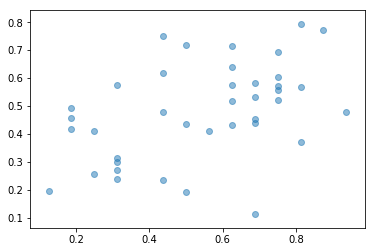

In [257]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('R2 Score: {}'.format(r2_score(y_test, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

_ = plt.scatter(y_test, y_pred, alpha=0.5)

## Forward Selection for Best Features

In [258]:
fs_models = {}

unused_vars = X_train.columns
model_vars = []

lr = LinearRegression()

for i in range(1, len(X_train.columns) + 1):
    best_score = -1e100
    for var in unused_vars:
        lr.fit(X_train[model_vars + [var]], y_train)
        score = lr.score(X_test[model_vars + [var]], y_test)
        if score > best_score:
            best_score = score
            best_model = lr
            best_var = var
    model_vars.append(best_var)
    unused_vars = unused_vars.drop(best_var)
    fs_models[i] = [best_score, model_vars.copy()]

In [259]:
max_score = 0

for key in fs_models.keys():
    if fs_models[key][0] > max_score:
        max_score = fs_models[key][0]
        num_vars = key
print('Best model (forward selection) has {} variables and an R2 score of {:.4}'.format(num_vars, max_score))

Best model (forward selection) has 12 variables and an R2 score of 0.345


In [260]:
best_vars = fs_models[num_vars][1]

In [261]:
lr.fit(X_train[best_vars], y_train)
y_pred = lr.predict(X_test[best_vars])

In [262]:
for i in range(len(y_pred)):
    print('Actual: {} - Predicted: {}'.format(y_test.iloc[i], y_pred[i]))

Actual: 0.75 - Predicted: 0.6011860059301469
Actual: 0.75 - Predicted: 0.601909684470863
Actual: 0.5 - Predicted: 0.4818811161947691
Actual: 0.625 - Predicted: 0.4414464964779155
Actual: 0.625 - Predicted: 0.5327652689312676
Actual: 0.4375 - Predicted: 0.5639895547411075
Actual: 0.75 - Predicted: 0.5452829390094814
Actual: 0.8125 - Predicted: 0.5315158833640042
Actual: 0.75 - Predicted: 0.5478096114624477
Actual: 0.5625 - Predicted: 0.4941080766163008
Actual: 0.8125 - Predicted: 0.4955794574570989
Actual: 0.25 - Predicted: 0.38990344060679566
Actual: 0.625 - Predicted: 0.5170278660506415
Actual: 0.6875 - Predicted: 0.41559545576131574
Actual: 0.4375 - Predicted: 0.290550801313208
Actual: 0.6875 - Predicted: 0.534812340838471
Actual: 0.25 - Predicted: 0.29492585402117155
Actual: 0.1875 - Predicted: 0.38387883556048563
Actual: 0.875 - Predicted: 0.6877231369086312
Actual: 0.3125 - Predicted: 0.3432342871858545
Actual: 0.4375 - Predicted: 0.43064268450262233
Actual: 0.5 - Predicted: 0.532